In [46]:
import torch
import torch.nn as nn
import torch.optim as optim

import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader

import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt


In [29]:

class SmallMLP(nn.Module):
    def __init__(self, hidden=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 10)
        )
    def forward(self, x):
        return self.net(x)


# ------------------------
# Load MNIST
# ------------------------
transform = transforms.Compose([
    transforms.ToTensor()
])

train_data = datasets.MNIST(root="./mnist", train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)


# ------------------------
# Train on a *single* class
# ------------------------
def train_on_class(target_class, epochs=2):
    model = SmallMLP()
    opt = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        for x, y in train_loader:
            mask = (y == target_class)
            if mask.sum() == 0:
                continue

            x = x[mask]
            y = y[mask]

            logits = model(x)
            loss = criterion(logits, y)

            opt.zero_grad()
            loss.backward()
            opt.step()

    return model


100%|██████████████████████████████████████| 9.91M/9.91M [00:01<00:00, 5.22MB/s]
100%|██████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 2.20MB/s]
100%|██████████████████████████████████████| 1.65M/1.65M [00:00<00:00, 5.49MB/s]
100%|██████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 4.57MB/s]


In [42]:

class_models = {}
for cls in range(10):
    print(f"Training class {cls}...")
    class_models[cls] = train_on_class(cls)



def flatten_params(model):
    return torch.cat([p.detach().cpu().flatten() for p in model.parameters()])


def pairwise_distances(models):
    dist = np.zeros((10,10))
    for i in range(10):
        for j in range(10):
            wi = flatten_params(models[i])
            wj = flatten_params(models[j])
            dist[i][j] = ((wi - wj)**2).sum().sqrt().item()
    return dist


dist_matrix = pairwise_distances(class_models)
print("Pairwise distance matrix between class minima:")
print(dist_matrix)




Training class 0...
Training class 1...
Training class 2...
Training class 3...
Training class 4...
Training class 5...
Training class 6...
Training class 7...
Training class 8...
Training class 9...
Pairwise distance matrix between class minima:
[[0.         8.40919018 9.0073843  8.40361595 9.13691425 8.44535637
  8.83730507 9.01537228 8.14323807 8.49955845]
 [8.40919018 0.         9.30291462 8.49185658 9.11207771 8.99402142
  9.05959797 9.03619289 8.37292004 8.52454185]
 [9.0073843  9.30291462 0.         8.90520477 9.03825665 8.97338486
  9.35212326 9.32087994 8.86558056 8.83215809]
 [8.40361595 8.49185658 8.90520477 0.         9.05877495 8.70769501
  8.73528004 8.55033112 8.30784416 8.4018507 ]
 [9.13691425 9.11207771 9.03825665 9.05877495 0.         8.78599644
  9.40655327 9.24277306 8.51701355 8.55017853]
 [8.44535637 8.99402142 8.97338486 8.70769501 8.78599644 0.
  9.15749836 8.98207378 8.41915512 8.42577934]
 [8.83730507 9.05959797 9.35212326 8.73528004 9.40655327 9.15749836
  0

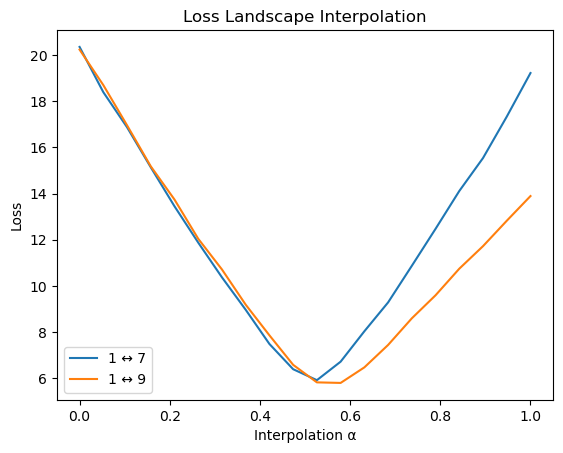

In [48]:

def interpolate_loss(modelA, modelB, loader, steps=20):
    wA = flatten_params(modelA)
    wB = flatten_params(modelB)

    alphas = torch.linspace(0, 1, steps)
    losses = []

    criterion = nn.CrossEntropyLoss()

    for a in alphas:
        # interpolated parameters
        w = (1 - a) * wA + a * wB
        idx = 0

        # load into temp model
        temp = SmallMLP()
        with torch.no_grad():
            for p in temp.parameters():
                num = p.numel()
                p.copy_(w[idx: idx+num].view_as(p))
                idx += num

        # compute average loss on a small subset
        total = 0; count = 0
        for x, y in loader:
            logits = temp(x)
            loss = criterion(logits, y)
            total += loss.item()
            count += 1
            if count == 20:   # small sample
                break
        losses.append(total / count)

    return alphas, losses


# Example: classes 1 vs 7 (similar), 1 vs 9 (less similar)
small_loader = torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=True)

alphas_17, loss_17 = interpolate_loss(class_models[1], class_models[7], small_loader)
alphas_19, loss_19 = interpolate_loss(class_models[1], class_models[9], small_loader)


plt.plot(alphas_17, loss_17, label="1 ↔ 7")
plt.plot(alphas_19, loss_19, label="1 ↔ 9")
plt.xlabel("Interpolation α")
plt.ylabel("Loss")
plt.title("Loss Landscape Interpolation")
plt.legend()
plt.show()




In [50]:
def hessian_spectral_norm(model, x, y, iters=10):
    criterion = nn.CrossEntropyLoss()

    logits = model(x)
    loss = criterion(logits, y)

    grad = torch.autograd.grad(loss, model.parameters(), create_graph=True)
    grad_vector = torch.cat([g.flatten() for g in grad])

    v = torch.randn_like(grad_vector)
    v = v / v.norm()

    for _ in range(iters):
        Hv = []
        idx = 0

        # second gradient trick
        gvHv = torch.dot(grad_vector, v)
        Hv_vec = torch.autograd.grad(gvHv, model.parameters(), retain_graph=True)
        Hv = torch.cat([h.flatten() for h in Hv_vec])

        v = Hv / (Hv.norm() + 1e-8)

    return torch.dot(v, Hv).sqrt().item()



hessian_norms = {}
for cls in range(10):
    print(f"Computing Hessian spectral norm for class {cls}...")
    x, y = next(iter(train_loader))
    x = x[:64]  # small subset
    y = torch.full_like(y[:64], cls)  # fake labels so gradient is well-defined

    hessian_norms[cls] = hessian_spectral_norm(class_models[cls], x, y)

print("Hessian spectral norms (sharpness per class):")
print(hessian_norms)


Computing Hessian spectral norm for class 0...
Computing Hessian spectral norm for class 1...
Computing Hessian spectral norm for class 2...
Computing Hessian spectral norm for class 3...
Computing Hessian spectral norm for class 4...
Computing Hessian spectral norm for class 5...
Computing Hessian spectral norm for class 6...
Computing Hessian spectral norm for class 7...
Computing Hessian spectral norm for class 8...
Computing Hessian spectral norm for class 9...
Hessian spectral norms (sharpness per class):
{0: 0.5232362151145935, 1: 0.06893263012170792, 2: 0.13734830915927887, 3: 0.11122885346412659, 4: 0.08176913857460022, 5: 0.21570228040218353, 6: 0.18685650825500488, 7: 0.06609020382165909, 8: 0.24157319962978363, 9: 0.2985123097896576}


In [54]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"


class SmallMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1)    # output logits for BCE
        )

    def forward(self, x):
        return self.net(x)



class BinaryMNIST(Dataset):
    def __init__(self, root, cls_a, cls_b, train=True):
        tf = transforms.Compose([transforms.ToTensor()])
        data = torchvision.datasets.MNIST(root, train=train, download=True, transform=tf)

        mask = (data.targets == cls_a) | (data.targets == cls_b)
        self.images = data.data[mask].unsqueeze(1).float() / 255.0

        labels = data.targets[mask]
        self.labels = (labels == cls_a).float()  # cls_a = 1, cls_b = 0

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, i):
        return self.images[i], self.labels[i]



def train_binary(model, trainloader, epochs=5, lr=1e-3):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.BCEWithLogitsLoss()

    for _ in range(epochs):
        for x, y in trainloader:
            x, y = x.to(device), y.to(device)
            logits = model(x).squeeze()
            loss = loss_fn(logits, y)

            opt.zero_grad()
            loss.backward()
            opt.step()

    return deepcopy(model)



def eval_stats(model, loader):
    model.eval()
    loss_fn = nn.BCEWithLogitsLoss()
    correct = 0
    total = 0
    total_loss = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x).squeeze()
            loss = loss_fn(logits, y).item()
            preds = (logits > 0).float()
            correct += (preds == y).sum().item()
            total += len(y)
            total_loss += loss * len(y)

    return correct / total, total_loss / total



def random_direction(model):
    vec = []
    for p in model.parameters():
        v = torch.randn_like(p)
        vec.append(v)

    total_norm = torch.sqrt(sum((v**2).sum() for v in vec))
    vec = [v / total_norm for v in vec]

    return vec



def perturb_model(model, direction, alpha):
    pert = deepcopy(model)
    with torch.no_grad():
        for p, d in zip(pert.parameters(), direction):
            p.add_(alpha * d)
    return pert



def basin_depth_scan(model, testloader, direction, alphas):
    base_acc, _ = eval_stats(model, testloader)
    results = []

    for a in alphas:
        pert = perturb_model(model, direction, a)
        acc, loss = eval_stats(pert, testloader)
        results.append((a, acc, base_acc - acc, loss))

    return results



def model_distance(m1, m2):
    s = 0
    for p1, p2 in zip(m1.parameters(), m2.parameters()):
        s += ((p1 - p2)**2).sum().item()
    return np.sqrt(s)


def linear_interp(m1, m2, testloader, steps=30):
    alphas = np.linspace(0, 1, steps)
    p1 = [p.detach().clone() for p in m1.parameters()]
    p2 = [p.detach().clone() for p in m2.parameters()]

    results = []
    for a in alphas:
        temp = deepcopy(m1)
        with torch.no_grad():
            for p, pa, pb in zip(temp.parameters(), p1, p2):
                p.copy_((1 - a) * pa + a * pb)

        acc, loss = eval_stats(temp, testloader)
        results.append((a, acc, loss))

    return results




Accuracy m1: 0.9972260748959778
Accuracy m2: 0.9944521497919556
Distance between minima: 19.28214675336672


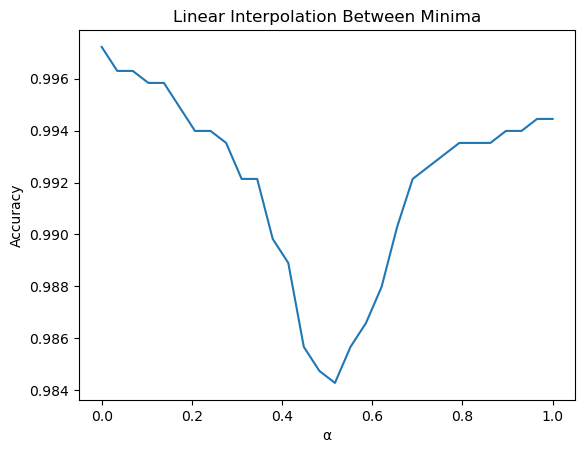

In [66]:

class_a = 1
class_b = 7

trainset = BinaryMNIST("./mnist", cls_a=class_a, cls_b=class_b, train=True)
testset  = BinaryMNIST("./mnist", cls_a=class_a, cls_b=class_b, train=False)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader  = DataLoader(testset, batch_size=256, shuffle=False)

# Train two different minima (different seeds)
torch.manual_seed(0)
m1 = train_binary(SmallMLP(), trainloader, epochs=3)

torch.manual_seed(1)
m2 = train_binary(SmallMLP(), trainloader, epochs=3)

# Evaluate both
acc1, _ = eval_stats(m1, testloader)
acc2, _ = eval_stats(m2, testloader)
print("Accuracy m1:", acc1)
print("Accuracy m2:", acc2)

# Basin scan for m1 along random direction
direction = random_direction(m1)
alphas = np.linspace(-5, 5, 41)
scan = basin_depth_scan(m1, testloader, direction, alphas)

# Interpolation between minima
interp = linear_interp(m1, m2, testloader)

print("Distance between minima:", model_distance(m1, m2))

# Plot interpolation curve
plt.plot([r[0] for r in interp], [r[1] for r in interp])
plt.xlabel("α")
plt.ylabel("Accuracy")
plt.title("Linear Interpolation Between Minima")
plt.show()


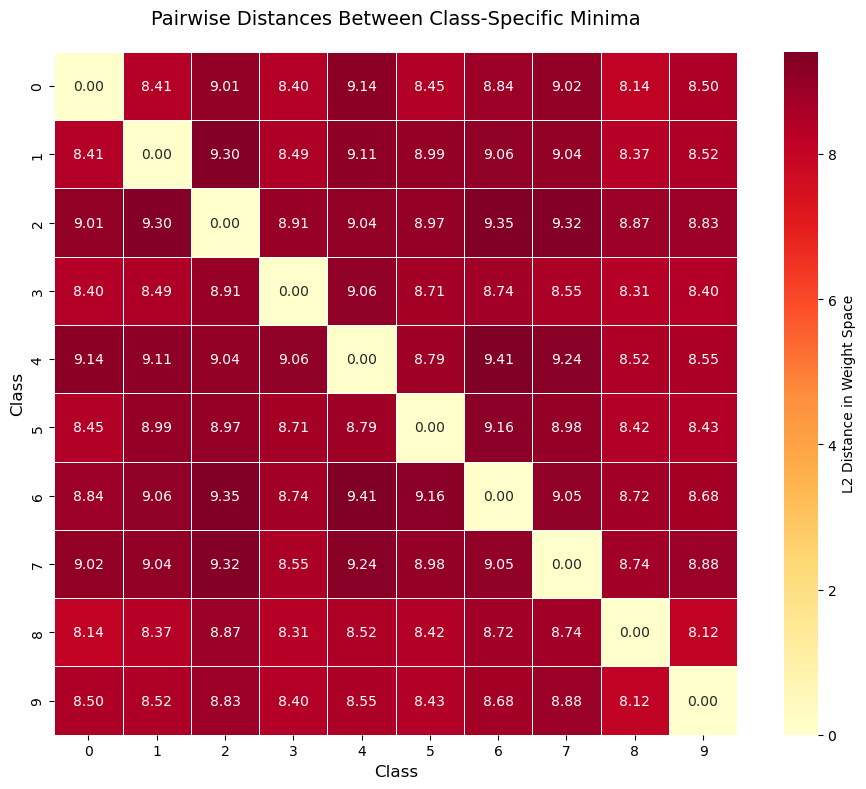


Notable class pairs:
1 vs 7 (similar): 9.036
3 vs 5 (similar): 8.708
8 vs 9 (similar): 8.124
0 vs 8 (dissimilar): 8.143
1 vs 0 (dissimilar): 8.409


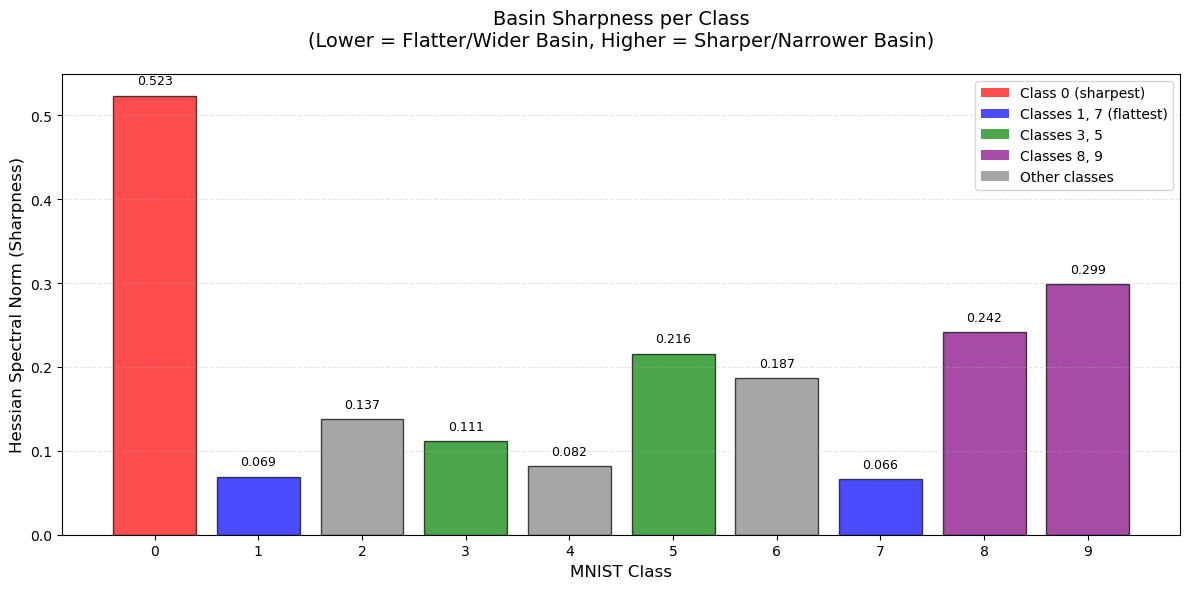


Spectral Norm Statistics:
Sharpest basin: Class 0 = 0.523
Flattest basin: Class 7 = 0.066
Mean: 0.193
Std: 0.133
CODE TO GENERATE PERTURBATION PLOT (run this after your basin_depth_scan):


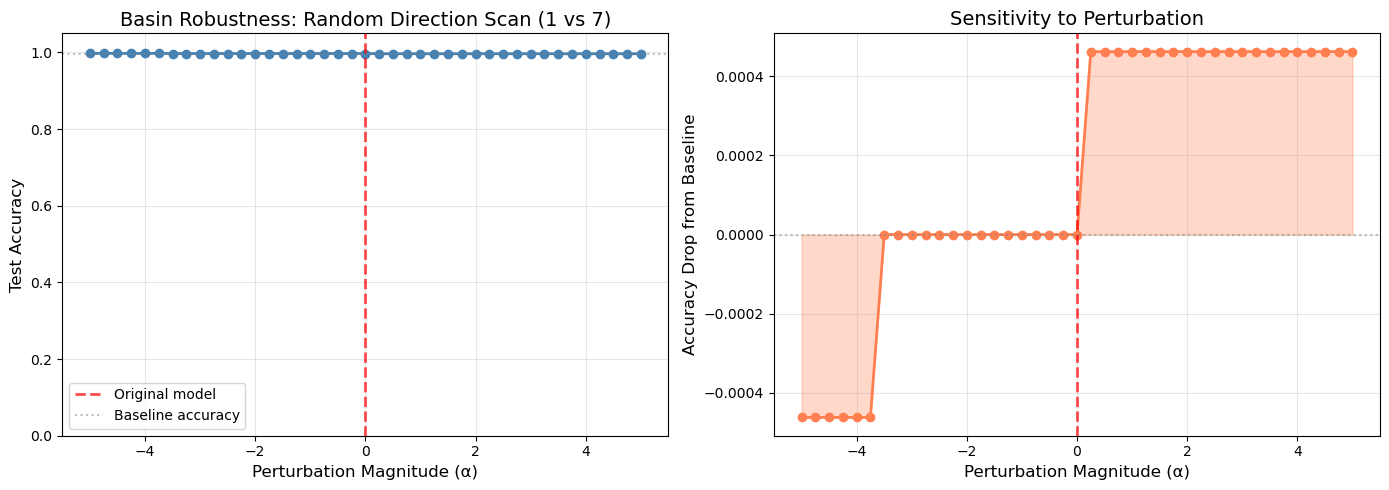

Basin width (accuracy > 95% baseline): 10.000


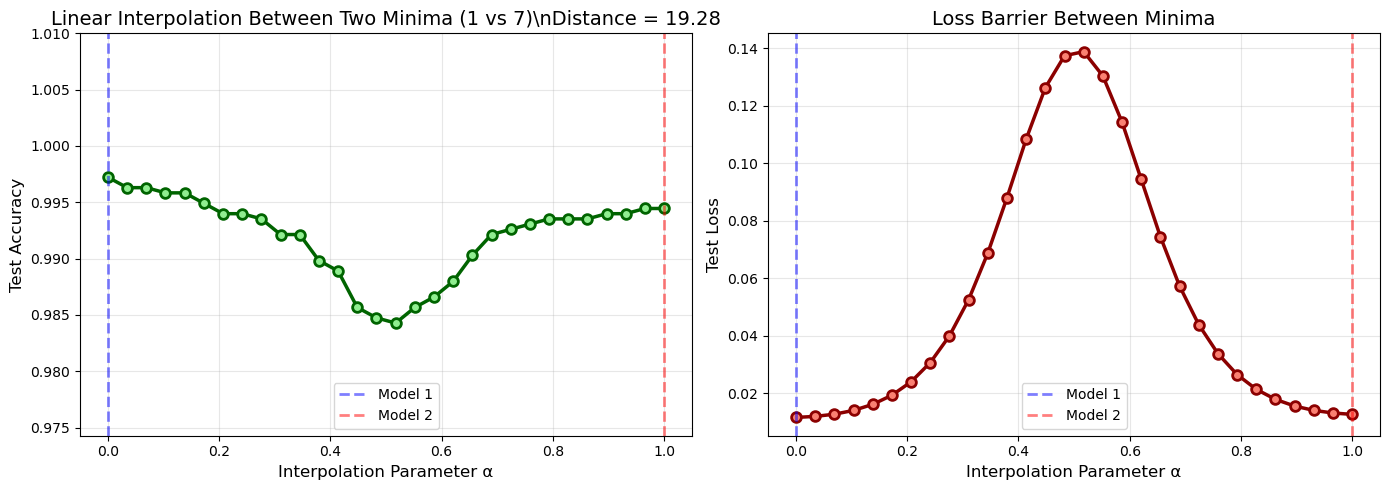

High barrier detected: Max loss = 0.139, Endpoint avg = 0.012
CODE FOR LOSS LANDSCAPE COMPARISON (from your existing code):


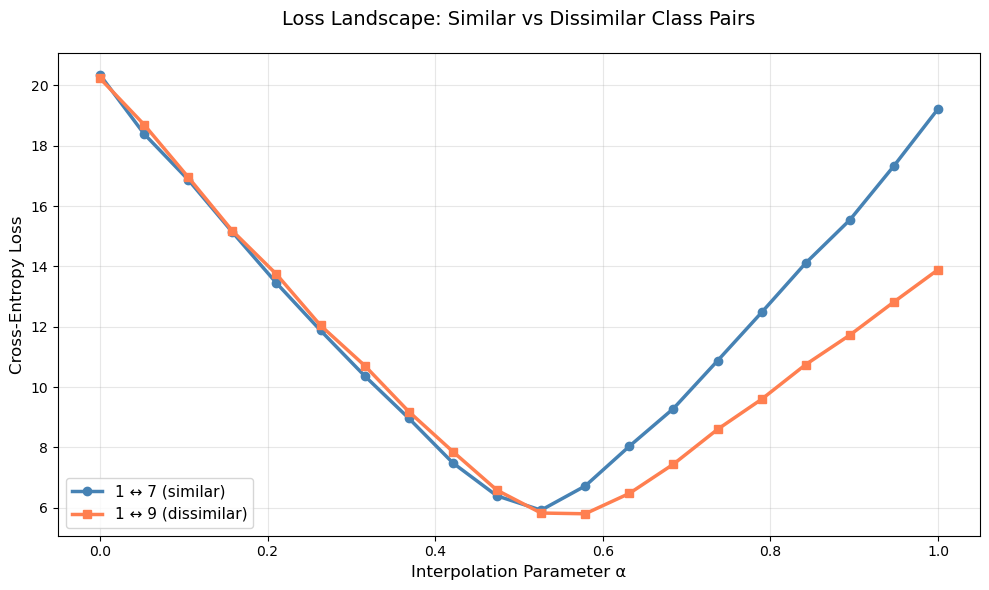

Barrier height (1↔7): 0.565
Barrier height (1↔9): 3.171


In [68]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


dist_matrix = np.array([
    [0., 8.40919018, 9.0073843, 8.40361595, 9.13691425, 8.44535637,
     8.83730507, 9.01537228, 8.14323807, 8.49955845],
    [8.40919018, 0., 9.30291462, 8.49185658, 9.11207771, 8.99402142,
     9.05959797, 9.03619289, 8.37292004, 8.52454185],
    [9.0073843, 9.30291462, 0., 8.90520477, 9.03825665, 8.97338486,
     9.35212326, 9.32087994, 8.86558056, 8.83215809],
    [8.40361595, 8.49185658, 8.90520477, 0., 9.05877495, 8.70769501,
     8.73528004, 8.55033112, 8.30784416, 8.4018507],
    [9.13691425, 9.11207771, 9.03825665, 9.05877495, 0., 8.78599644,
     9.40655327, 9.24277306, 8.51701355, 8.55017853],
    [8.44535637, 8.99402142, 8.97338486, 8.70769501, 8.78599644, 0.,
     9.15749836, 8.98207378, 8.41915512, 8.42577934],
    [8.83730507, 9.05959797, 9.35212326, 8.73528004, 9.40655327, 9.15749836,
     0., 9.05368996, 8.72179508, 8.68237972],
    [9.01537228, 9.03619289, 9.32087994, 8.55033112, 9.24277306, 8.98207378,
     9.05368996, 0., 8.73985004, 8.87640381],
    [8.14323807, 8.37292004, 8.86558056, 8.30784416, 8.51701355, 8.41915512,
     8.72179508, 8.73985004, 0., 8.12443161],
    [8.49955845, 8.52454185, 8.83215809, 8.4018507, 8.55017853, 8.42577934,
     8.68237972, 8.87640381, 8.12443161, 0.]
])

plt.figure(figsize=(10, 8))
sns.heatmap(dist_matrix, 
            annot=True, 
            fmt='.2f', 
            cmap='YlOrRd',
            xticklabels=range(10),
            yticklabels=range(10),
            cbar_kws={'label': 'L2 Distance in Weight Space'},
            square=True,
            linewidths=0.5)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Class', fontsize=12)
plt.title('Pairwise Distances Between Class-Specific Minima', fontsize=14, pad=20)
plt.tight_layout()
plt.savefig('distance_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


print("\nNotable class pairs:")
print(f"1 vs 7 (similar): {dist_matrix[1, 7]:.3f}")
print(f"3 vs 5 (similar): {dist_matrix[3, 5]:.3f}")
print(f"8 vs 9 (similar): {dist_matrix[8, 9]:.3f}")
print(f"0 vs 8 (dissimilar): {dist_matrix[0, 8]:.3f}")
print(f"1 vs 0 (dissimilar): {dist_matrix[1, 0]:.3f}")


hessian_norms = {
    0: 0.5232362151145935, 
    1: 0.06893263012170792, 
    2: 0.13734830915927887, 
    3: 0.11122885346412659, 
    4: 0.08176913857460022, 
    5: 0.21570228040218353, 
    6: 0.18685650825500488, 
    7: 0.06609020382165909, 
    8: 0.24157319962978363, 
    9: 0.2985123097896576
}

classes = list(hessian_norms.keys())
norms = list(hessian_norms.values())

# Color code: highlight similar pairs
colors = ['red' if c == 0 else 
          'blue' if c in [1, 7] else 
          'green' if c in [3, 5] else 
          'purple' if c in [8, 9] else 
          'gray' for c in classes]

plt.figure(figsize=(12, 6))
bars = plt.bar(classes, norms, color=colors, alpha=0.7, edgecolor='black')
plt.xlabel('MNIST Class', fontsize=12)
plt.ylabel('Hessian Spectral Norm (Sharpness)', fontsize=12)
plt.title('Basin Sharpness per Class\n(Lower = Flatter/Wider Basin, Higher = Sharper/Narrower Basin)', 
          fontsize=14, pad=20)
plt.xticks(classes)
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for i, (cls, norm) in enumerate(zip(classes, norms)):
    plt.text(cls, norm + 0.01, f'{norm:.3f}', 
             ha='center', va='bottom', fontsize=9)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', alpha=0.7, label='Class 0 (sharpest)'),
    Patch(facecolor='blue', alpha=0.7, label='Classes 1, 7 (flattest)'),
    Patch(facecolor='green', alpha=0.7, label='Classes 3, 5'),
    Patch(facecolor='purple', alpha=0.7, label='Classes 8, 9'),
    Patch(facecolor='gray', alpha=0.7, label='Other classes')
]
plt.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.tight_layout()
plt.savefig('spectral_norms_bar.png', dpi=300, bbox_inches='tight')
plt.show()

# Print statistics
print("\nSpectral Norm Statistics:")
print(f"Sharpest basin: Class {max(hessian_norms, key=hessian_norms.get)} = {max(norms):.3f}")
print(f"Flattest basin: Class {min(hessian_norms, key=hessian_norms.get)} = {min(norms):.3f}")
print(f"Mean: {np.mean(norms):.3f}")
print(f"Std: {np.std(norms):.3f}")



# You need to run this after your basin scan code
# This assumes you have 'scan' variable from: 
scan = basin_depth_scan(m1, testloader, direction, alphas)

# For demonstration, I'll create example code you should run:

print("CODE TO GENERATE PERTURBATION PLOT (run this after your basin_depth_scan):")



# After running: scan = basin_depth_scan(m1, testloader, direction, alphas)

alphas = [s[0] for s in scan]
accs = [s[1] for s in scan]
acc_drops = [s[2] for s in scan]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: Accuracy vs perturbation
ax1.plot(alphas, accs, 'o-', linewidth=2, markersize=6, color='steelblue')
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Original model')
ax1.axhline(y=accs[len(alphas)//2], color='gray', linestyle=':', alpha=0.5, label='Baseline accuracy')
ax1.set_xlabel('Perturbation Magnitude (α)', fontsize=12)
ax1.set_ylabel('Test Accuracy', fontsize=12)
ax1.set_title('Basin Robustness: Random Direction Scan (1 vs 7)', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_ylim([0, 1.05])

# Right plot: Accuracy drop from baseline
ax2.plot(alphas, acc_drops, 'o-', linewidth=2, markersize=6, color='coral')
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax2.axhline(y=0, color='gray', linestyle=':', alpha=0.5)
ax2.set_xlabel('Perturbation Magnitude (α)', fontsize=12)
ax2.set_ylabel('Accuracy Drop from Baseline', fontsize=12)
ax2.set_title('Sensitivity to Perturbation', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.fill_between(alphas, 0, acc_drops, alpha=0.3, color='coral')

plt.tight_layout()
plt.savefig('basin_perturbation_scan.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate basin "width" (range where accuracy > 95% of baseline)
baseline_acc = accs[len(alphas)//2]
threshold = 0.95 * baseline_acc
robust_range = [a for a, acc in zip(alphas, accs) if acc >= threshold]
if len(robust_range) > 0:
    basin_width = max(robust_range) - min(robust_range)
    print(f"Basin width (accuracy > 95% baseline): {basin_width:.3f}")


# ============================================================================
# 4. INTERPOLATION PLOT (between two minima)
# ============================================================================




interp = linear_interp(m1, m2, testloader)

alphas_interp = [r[0] for r in interp]
accs_interp = [r[1] for r in interp]
losses_interp = [r[2] for r in interp]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Accuracy along interpolation
ax1.plot(alphas_interp, accs_interp, 'o-', linewidth=2.5, markersize=7, 
         color='darkgreen', markerfacecolor='lightgreen', markeredgewidth=2)
ax1.axvline(x=0, color='blue', linestyle='--', linewidth=2, alpha=0.5, label='Model 1')
ax1.axvline(x=1, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Model 2')
ax1.set_xlabel('Interpolation Parameter α', fontsize=12)
ax1.set_ylabel('Test Accuracy', fontsize=12)
ax1.set_title('Linear Interpolation Between Two Minima (1 vs 7)\\n' + 
              f'Distance = {model_distance(m1, m2):.2f}', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_ylim([min(accs_interp) - 0.01, 1.01])

# Right: Loss along interpolation
ax2.plot(alphas_interp, losses_interp, 'o-', linewidth=2.5, markersize=7,
         color='darkred', markerfacecolor='salmon', markeredgewidth=2)
ax2.axvline(x=0, color='blue', linestyle='--', linewidth=2, alpha=0.5, label='Model 1')
ax2.axvline(x=1, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Model 2')
ax2.set_xlabel('Interpolation Parameter α', fontsize=12)
ax2.set_ylabel('Test Loss', fontsize=12)
ax2.set_title('Loss Barrier Between Minima', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig('interpolation_between_minima.png', dpi=300, bbox_inches='tight')
plt.show()

# Check for mode connectivity
max_loss = max(losses_interp)
endpoint_loss = (losses_interp[0] + losses_interp[-1]) / 2
if max_loss < 1.1 * endpoint_loss:
    print("Mode connectivity detected: Low barrier between minima")
else:
    print(f"High barrier detected: Max loss = {max_loss:.3f}, Endpoint avg = {endpoint_loss:.3f}")


# ============================================================================
# BONUS: Loss Landscape for 1↔7 vs 1↔9
# ============================================================================


print("CODE FOR LOSS LANDSCAPE COMPARISON (from your existing code):")



# You already have this data from your code:
# alphas_17, loss_17 = interpolate_loss(class_models[1], class_models[7], small_loader)
# alphas_19, loss_19 = interpolate_loss(class_models[1], class_models[9], small_loader)

plt.figure(figsize=(10, 6))
plt.plot(alphas_17.numpy(), loss_17, 'o-', linewidth=2.5, markersize=6, 
         label='1 ↔ 7 (similar)', color='steelblue')
plt.plot(alphas_19.numpy(), loss_19, 's-', linewidth=2.5, markersize=6,
         label='1 ↔ 9 (dissimilar)', color='coral')
plt.xlabel('Interpolation Parameter α', fontsize=12)
plt.ylabel('Cross-Entropy Loss', fontsize=12)
plt.title('Loss Landscape: Similar vs Dissimilar Class Pairs', fontsize=14, pad=20)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('loss_landscape_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Compare barrier heights
barrier_17 = max(loss_17) - (loss_17[0] + loss_17[-1]) / 2
barrier_19 = max(loss_19) - (loss_19[0] + loss_19[-1]) / 2
print(f"Barrier height (1↔7): {barrier_17:.3f}")
print(f"Barrier height (1↔9): {barrier_19:.3f}")

